## 1. 导入模块

In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel

from attention_extraction import extract_abc_mamba2, calculate_alpha_mamba2_simple

# 配置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 优先使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

print(f"Device: {device}")
print(f"Dtype: {dtype}")

/root/miniconda3/envs/mamba2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda:0
Dtype: torch.float32


## 2. 加载模型

In [3]:
# 加载tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
model = MambaLMHeadModel.from_pretrained("state-spaces/mamba2-2.7b", device=device, dtype=dtype)
model.eval()

print(f"模型加载成功！")
print(f"模型层数: {len(model.backbone.layers)}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


模型加载成功！
模型层数: 64


## 3. 提取SSM参数

从指定层提取A, B, C, x, D, dt等参数

**重要说明**：
- Mamba2官方API：`mamba_chunk_scan_combined(x, dt, A, B, C, ...)`
- 直接传递**原始参数**，离散化在kernel内部完成
- 我们计算的`discrete_A = exp(A*dt)`和`discrete_B = dt*B`只是为了在Python层面模拟递推，**不是官方术语**

In [4]:
# 定义输入文本
prompt = "Hello world! This is a test."
layer_idx = 0  # 提取第0层

# 提取参数
layer_data = extract_abc_mamba2(model, tokenizer, prompt, layer_idx=layer_idx, device=device)

print(f"提取完成！可用的键: {list(layer_data.keys())}")

提取完成！可用的键: ['discrete_A', 'discrete_B', 'C', 'dt', 'x', 'nheads', 'headdim', 'ngroups', 'd_state', 'D', 'z', 'A', 'dt_bias', 'chunk_size', 'out_proj', 'layer_output']


## 4. 查看参数形状

**术语说明**：
- **官方Mamba2**: 传递原始的`A, B, C, dt`，离散化在kernel内部
- **我们的实现**: 为了Python层面的alpha计算，预先计算`discrete_A = exp(A*dt)`和`discrete_B = dt*B`
- 这些"discrete"术语是**我们的命名**，不是Mamba2官方API的一部分

In [5]:
# 查看所有参数的形状
print("=" * 60)
print("参数形状:")
print("=" * 60)

discrete_A = layer_data['discrete_A']  # 我们计算的 exp(A*dt)
discrete_B = layer_data['discrete_B']  # 我们计算的 dt*B
C = layer_data['C']
x = layer_data['x']
D = layer_data['D']
dt = layer_data['dt']

print("我们预计算的离散化参数（方便alpha计算）:")
print(f"  discrete_A: {discrete_A.shape}  # exp(A*dt)")
print(f"  discrete_B: {discrete_B.shape}  # dt*B")
print()
print("Mamba2原始参数（官方API使用）:")
print(f"  C:  {C.shape}  # [batch, seqlen, ngroups, d_state]")
print(f"  x:  {x.shape}  # [batch, seqlen, nheads, headdim]")
print(f"  dt: {dt.shape}  # [batch, seqlen, nheads]")
print(f"  D:  {D.shape}  # [nheads]")

print("\n架构参数:")
print(f"  nheads:   {layer_data['nheads']}")
print(f"  headdim:  {layer_data['headdim']}")
print(f"  ngroups:  {layer_data['ngroups']}")
print(f"  d_state:  {layer_data['d_state']}")
print(f"  seqlen:   {discrete_A.shape[1]}")

print("\n💡 注意：Mamba2官方实现直接传递A, B, dt给kernel，离散化在内部完成")

参数形状:
我们预计算的离散化参数（方便alpha计算）:
  discrete_A: torch.Size([1, 8, 80, 64, 128])  # exp(A*dt)
  discrete_B: torch.Size([1, 8, 80, 1, 128])  # dt*B

Mamba2原始参数（官方API使用）:
  C:  torch.Size([1, 8, 1, 128])  # [batch, seqlen, ngroups, d_state]
  x:  torch.Size([1, 8, 80, 64])  # [batch, seqlen, nheads, headdim]
  dt: torch.Size([1, 8, 80])  # [batch, seqlen, nheads]
  D:  torch.Size([80])  # [nheads]

架构参数:
  nheads:   80
  headdim:  64
  ngroups:  1
  d_state:  128
  seqlen:   8

💡 注意：Mamba2官方实现直接传递A, B, dt给kernel，离散化在内部完成


## 5. 查看参数数值范围

In [6]:
# 查看每个参数的统计信息
def show_stats(tensor, name):
    print(f"\n{name}:")
    print(f"  min:  {tensor.min().item():.6f}")
    print(f"  max:  {tensor.max().item():.6f}")
    print(f"  mean: {tensor.mean().item():.6f}")
    print(f"  std:  {tensor.std().item():.6f}")

show_stats(discrete_A, "discrete_A")
show_stats(discrete_B, "discrete_B")
show_stats(C, "C")
show_stats(x, "x")
show_stats(D, "D")


discrete_A:
  min:  0.634315
  max:  0.999433
  mean: 0.949625
  std:  0.037251

discrete_B:
  min:  -0.038071
  max:  1.846677
  mean: 0.002510
  std:  0.015884

C:
  min:  -0.278464
  max:  22.016439
  mean: 0.340004
  std:  1.451398

x:
  min:  -0.278456
  max:  9.609815
  mean: 0.017308
  std:  0.205869

D:
  min:  0.324382
  max:  2.043774
  mean: 0.587061
  std:  0.227524


## 6. 可视化discrete_A的分布

discrete_A = exp(A*dt) 应该接近1（因为A是负数，dt很小，所以exp(A*dt)略小于1）

这是**状态衰减因子**：越接近1表示状态保持越好

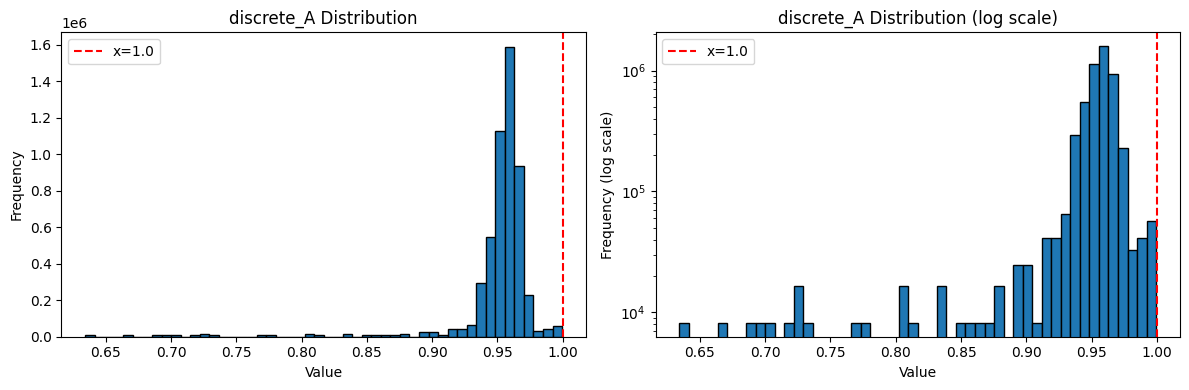

Most values of discrete_A should be close to 1 (decay factor)


In [7]:
# 可视化discrete_A的分布
A_flat = discrete_A.flatten().cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(A_flat, bins=50, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('discrete_A Distribution')
plt.axvline(1.0, color='r', linestyle='--', label='x=1.0')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(A_flat, bins=50, edgecolor='black', log=True)
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('discrete_A Distribution (log scale)')
plt.axvline(1.0, color='r', linestyle='--', label='x=1.0')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Most values of discrete_A should be close to 1 (decay factor)")

## 7. 查看具体位置的参数

查看特定时间步的参数值

In [8]:
# 查看第一个token (t=0) 的参数
t = 0
h = 0  # head 0
p = 0  # headdim 0

print(f"时间步 t={t}, head={h}, headdim={p}:")
print(f"\ndiscrete_A[0, {t}, {h}, {p}, :5]: {discrete_A[0, t, h, p, :5]}")
print(f"discrete_B[0, {t}, {h}, 0, :5]: {discrete_B[0, t, h, 0, :5]}  # dt*B")
print(f"C[0, {t}, 0, :5]: {C[0, t, 0, :5]}")
print(f"x[0, {t}, {h}, {p}]: {x[0, t, h, p]}")
print(f"dt[0, {t}, {h}]: {dt[0, t, h]}")
print(f"D[{h}]: {D[h]}")

时间步 t=0, head=0, headdim=0:

discrete_A[0, 0, 0, 0, :5]: tensor([0.9595, 0.9595, 0.9595, 0.9595, 0.9595], device='cuda:0')
discrete_B[0, 0, 0, 0, :5]: tensor([ 0.0003,  0.0002,  0.0004, -0.0022, -0.0005], device='cuda:0')  # dt*B
C[0, 0, 0, :5]: tensor([ 0.3903, -0.0951, -0.2660,  0.2513, -0.1774], device='cuda:0')
x[0, 0, 0, 0]: 0.07818946242332458
dt[0, 0, 0]: 0.012906714342534542
D[0]: 0.5705025792121887


## 8. 计算对角线的C@B贡献

验证对角线 = C@B + D

In [9]:
# 计算第一个位置的C@B
t = 0
batch = 0

# 简化：假设ngroups=1
B_t = discrete_B[batch, t].squeeze(1)  # [nheads, d_state]
C_t = C[batch, t].squeeze(0)  # [d_state]
D_val = D  # [nheads]

# C@B for each head: sum over d_state dimension
CB = torch.einsum('n,hn->h', C_t, B_t)  # [nheads]

print(f"位置 t={t}:")
print(f"\nC@B 贡献 (per head):")
print(f"  Head 0: {CB[0].item():.6f}")
print(f"  Head 1: {CB[1].item():.6f}")
print(f"  Head 2: {CB[2].item():.6f}")

print(f"\nD 贡献:")
print(f"  Head 0: {D_val[0].item():.6f}")
print(f"  Head 1: {D_val[1].item():.6f}")
print(f"  Head 2: {D_val[2].item():.6f}")

print(f"\n对角线 = C@B + D:")
diagonal = CB + D_val
print(f"  Head 0: {diagonal[0].item():.6f}")
print(f"  Head 1: {diagonal[1].item():.6f}")
print(f"  Head 2: {diagonal[2].item():.6f}")

位置 t=0:

C@B 贡献 (per head):
  Head 0: 0.053767
  Head 1: 0.057862
  Head 2: 0.085998

D 贡献:
  Head 0: 0.570503
  Head 1: 0.546273
  Head 2: 0.504950

对角线 = C@B + D:
  Head 0: 0.624270
  Head 1: 0.604135
  Head 2: 0.590947


## 9. 计算Alpha矩阵

使用`calculate_alpha_mamba2_simple`函数计算alpha矩阵

**两种模式**：
- 不传D：只得到SSM部分（对角线 = C@B）
- 传D：得到完整alpha（对角线 = C@B + D）

In [10]:
# 计算alpha矩阵（不包含D）
alpha_ssm = calculate_alpha_mamba2_simple(discrete_A, discrete_B, C, D=None)

# 计算完整alpha矩阵（包含D）
alpha_complete = calculate_alpha_mamba2_simple(discrete_A, discrete_B, C, D=D)

print(f"alpha_ssm shape: {alpha_ssm.shape}  # [seqlen, seqlen, nheads, headdim]")
print(f"alpha_complete shape: {alpha_complete.shape}")

print(f"\n【对角线对比】")
print(f"alpha_ssm[0,0,0,0] (仅C@B):     {alpha_ssm[0, 0, 0, 0].item():.6f}")
print(f"alpha_complete[0,0,0,0] (C@B+D): {alpha_complete[0, 0, 0, 0].item():.6f}")
print(f"D[0]:                            {D[0].item():.6f}")
print(f"验证: {alpha_ssm[0,0,0,0].item():.6f} + {D[0].item():.6f} = {(alpha_ssm[0,0,0,0] + D[0]).item():.6f}")

print(f"\n【非对角线】（应该相同，因为D只影响对角线）")
print(f"alpha_ssm[1,0,0,0]:      {alpha_ssm[1, 0, 0, 0].item():.6f}")
print(f"alpha_complete[1,0,0,0]: {alpha_complete[1, 0, 0, 0].item():.6f}")

alpha_ssm shape: torch.Size([8, 8, 80, 64])  # [seqlen, seqlen, nheads, headdim]
alpha_complete shape: torch.Size([8, 8, 80, 64])

【对角线对比】
alpha_ssm[0,0,0,0] (仅C@B):     0.053767
alpha_complete[0,0,0,0] (C@B+D): 0.624270
D[0]:                            0.570503
验证: 0.053767 + 0.570503 = 0.624270

【非对角线】（应该相同，因为D只影响对角线）
alpha_ssm[1,0,0,0]:      0.052350
alpha_complete[1,0,0,0]: 0.052350


## 10. 可视化Alpha矩阵

对比SSM部分和完整alpha矩阵的对角线

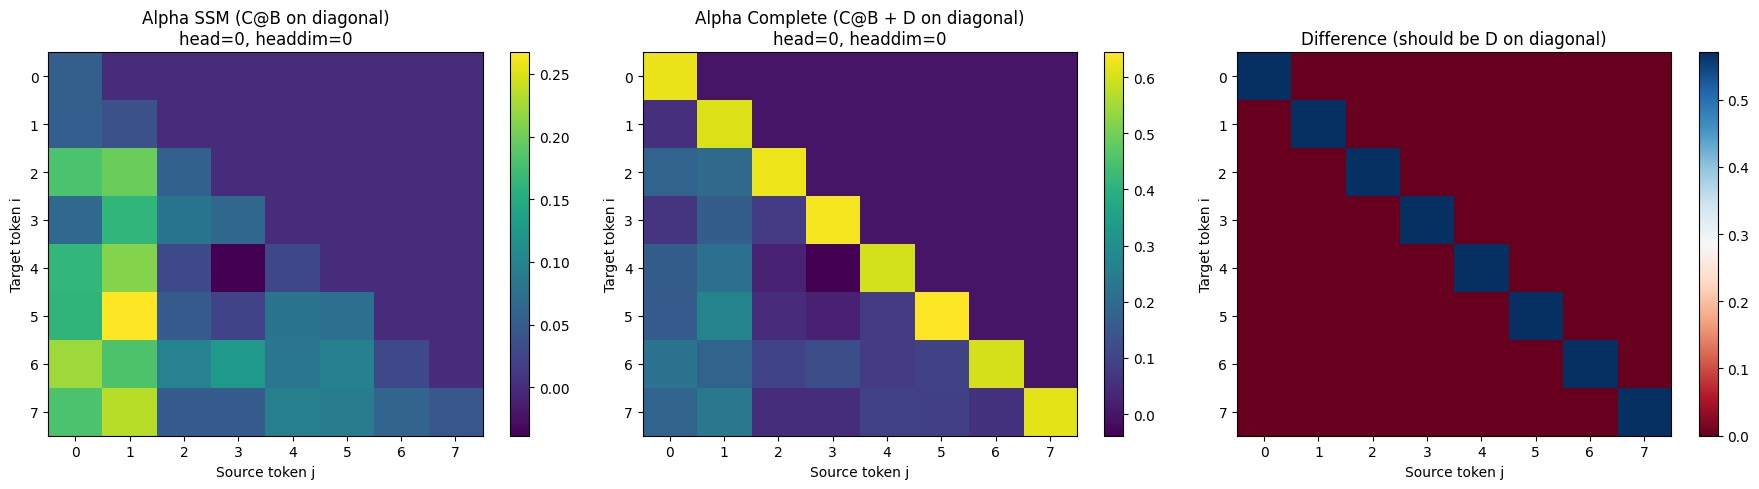

Diagonal values:
  alpha_ssm diagonal[0]:      0.0538
  alpha_complete diagonal[0]: 0.6243
  D[0]:                     0.5705


In [15]:
# 选择一个head和headdim来可视化
h = 0
p = 0

# 对比SSM部分和完整alpha
alpha_ssm_slice = alpha_ssm[:, :, h, p].detach().cpu().numpy()
alpha_complete_slice = alpha_complete[:, :, h, p].detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SSM部分
im1 = axes[0].imshow(alpha_ssm_slice, cmap='viridis', aspect='auto')
axes[0].set_xlabel('Source token j')
axes[0].set_ylabel('Target token i')
axes[0].set_title(f'Alpha SSM (C@B on diagonal)\nhead={h}, headdim={p}')
plt.colorbar(im1, ax=axes[0])

# 完整alpha
im2 = axes[1].imshow(alpha_complete_slice, cmap='viridis', aspect='auto')
axes[1].set_xlabel('Source token j')
axes[1].set_ylabel('Target token i')
axes[1].set_title(f'Alpha Complete (C@B + D on diagonal)\nhead={h}, headdim={p}')
plt.colorbar(im2, ax=axes[1])

# 差异（应该只在对角线有值）
diff = alpha_complete_slice - alpha_ssm_slice
im3 = axes[2].imshow(diff, cmap='RdBu', aspect='auto')
axes[2].set_xlabel('Source token j')
axes[2].set_ylabel('Target token i')
axes[2].set_title('Difference (should be D on diagonal)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"Diagonal values:")
print(f"  alpha_ssm diagonal[0]:      {alpha_ssm_slice[0,0]:.4f}")
print(f"  alpha_complete diagonal[0]: {alpha_complete_slice[0,0]:.4f}")
print(f"  D[{h}]:                     {D[h].item():.4f}")

## 11. 验证：与真实模型输出对比

使用完整alpha矩阵重构输出，与真实mamba kernel输出对比

In [12]:
# 从validation逻辑中获取ground truth
from mamba_ssm.ops.triton.ssd_combined import mamba_chunk_scan_combined

# 恢复原始B参数
dt_for_head0 = dt[:, :, 0].unsqueeze(-1).unsqueeze(-1)
B_recovered = discrete_B[:, :, 0, :, :] / dt_for_head0

# 调用真实kernel
with torch.no_grad():
    y_real = mamba_chunk_scan_combined(
        x, dt, layer_data['A'], B_recovered, C,
        chunk_size=layer_data['chunk_size'],
        D=D, z=None, dt_bias=None, dt_softplus=False,
    )
    if isinstance(y_real, tuple):
        y_real = y_real[0]

# 用alpha重构
y_reconstructed = torch.einsum('ijhp,jhp->ihp', alpha_complete, x[0])

# 对比
y_real_batch0 = y_real[0]
cos_sim = torch.nn.functional.cosine_similarity(
    y_reconstructed.flatten(), y_real_batch0.flatten(), dim=0
)

print("【验证结果】")
print(f"Real output shape:      {y_real_batch0.shape}")
print(f"Reconstructed shape:    {y_reconstructed.shape}")
print(f"\nCosine Similarity:      {cos_sim.item():.10f}")
print(f"Mean absolute error:    {(y_reconstructed - y_real_batch0).abs().mean().item():.6e}")
print(f"Max absolute error:     {(y_reconstructed - y_real_batch0).abs().max().item():.6e}")
print(f"\n{'✅ PERFECT MATCH!' if cos_sim.item() > 0.9999 else '❌ MISMATCH'}")

【验证结果】
Real output shape:      torch.Size([8, 80, 64])
Reconstructed shape:    torch.Size([8, 80, 64])

Cosine Similarity:      1.0000000000
Mean absolute error:    7.130590e-05
Max absolute error:     2.797318e-02

✅ PERFECT MATCH!


## 12. 探索：不同head的attention模式

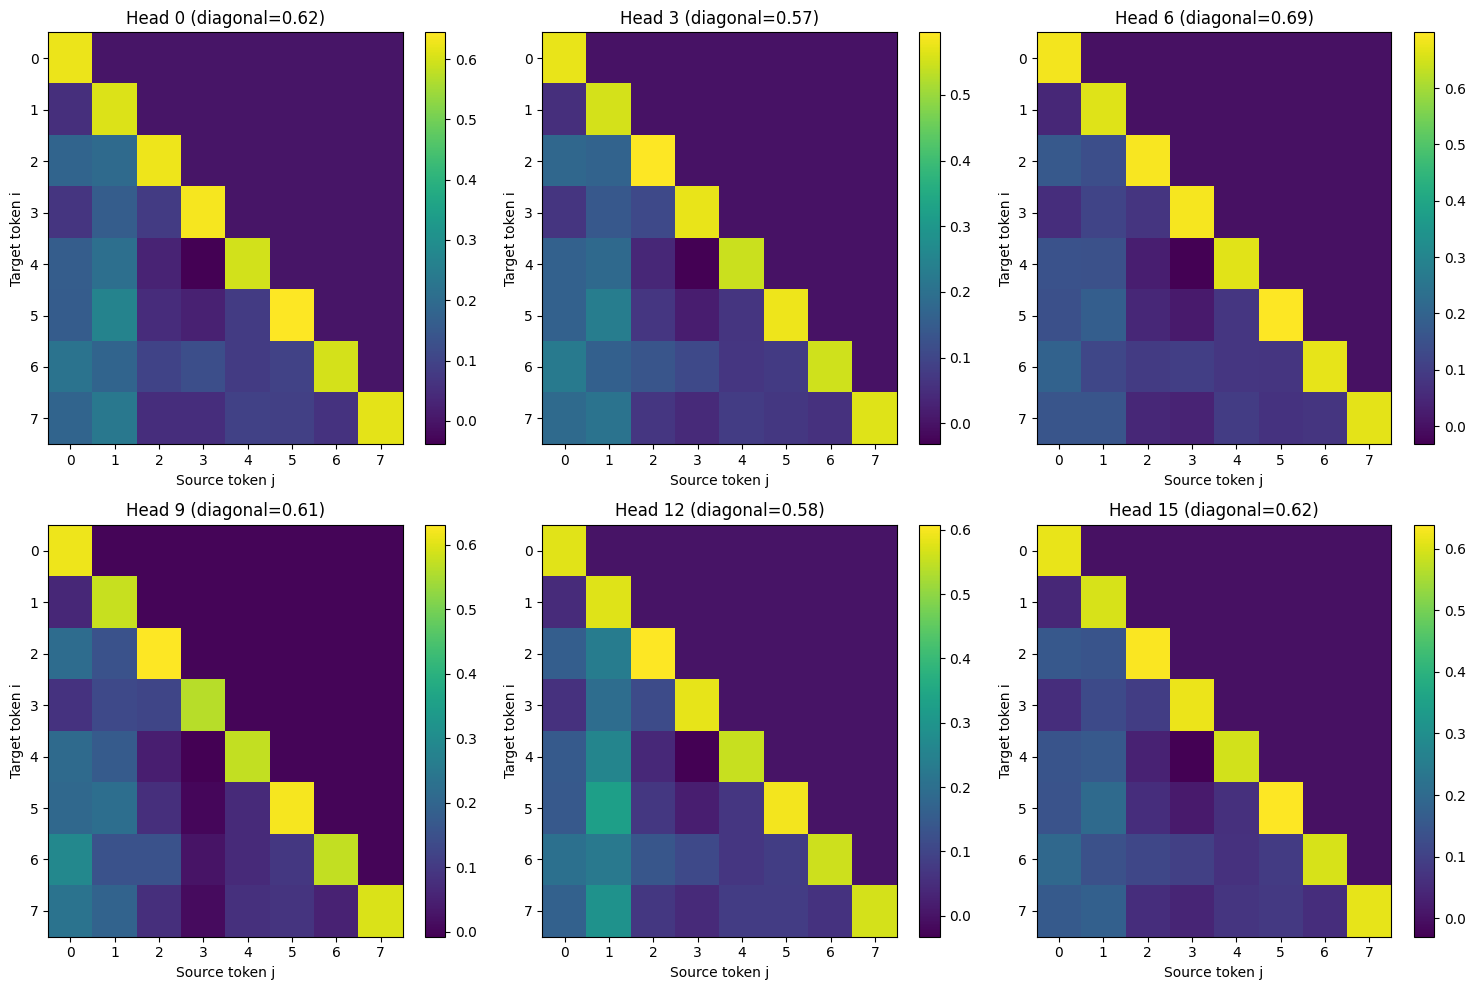

Different heads learn different dependency patterns
Notice diagonal values vary due to different D values per head


In [16]:
# 对比不同head的完整alpha矩阵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

heads_to_show = [0, 3, 6, 9, 12, 15]
for idx, h in enumerate(heads_to_show):
    alpha_slice = alpha_complete[:, :, h, 0].detach().cpu().numpy()
    
    im = axes[idx].imshow(alpha_slice, cmap='viridis', aspect='auto')
    axes[idx].set_xlabel('Source token j')
    axes[idx].set_ylabel('Target token i')
    axes[idx].set_title(f'Head {h} (diagonal={alpha_slice[0,0]:.2f})')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

print("Different heads learn different dependency patterns")
print("Notice diagonal values vary due to different D values per head")

## 13. 探索：Token影响力衰减

查看第一个token对后续token的影响如何随时间衰减

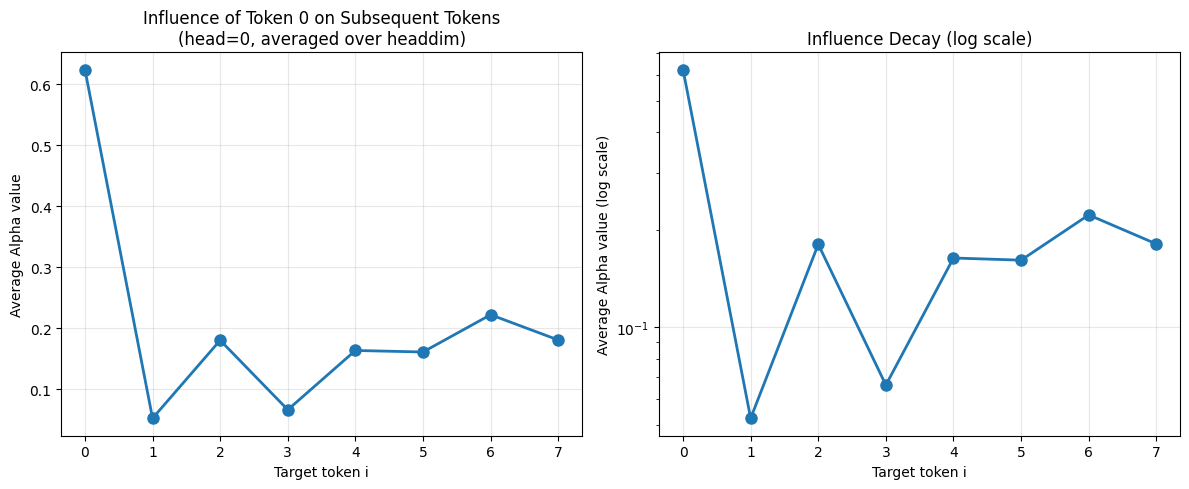

Token 0 influence decays exponentially due to state decay (A < 1)
Initial influence: 0.6243
Final influence: 0.1808
Decay ratio: 0.2896


In [17]:
# 选择source token
j = 0  # 第一个token
h = 0  # head 0

# alpha[:, j, h, :] represents influence of token j on all positions
# Average over headdim for simplicity
influence = alpha_complete[:, j, h, :].mean(dim=-1).detach().cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(influence, marker='o', linewidth=2, markersize=8)
plt.xlabel('Target token i')
plt.ylabel('Average Alpha value')
plt.title(f'Influence of Token {j} on Subsequent Tokens\n(head={h}, averaged over headdim)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(influence, marker='o', linewidth=2, markersize=8)
plt.xlabel('Target token i')
plt.ylabel('Average Alpha value (log scale)')
plt.title(f'Influence Decay (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Token {j} influence decays exponentially due to state decay (A < 1)")
print(f"Initial influence: {influence[0]:.4f}")
print(f"Final influence: {influence[-1]:.4f}")
print(f"Decay ratio: {influence[-1]/influence[0]:.4f}")

## 16. 总结与下一步探索

通过这个notebook，你已经探索了：
- ✅ 提取Mamba2的SSM参数
- ✅ 计算完整alpha矩阵（包含D）
- ✅ 验证alpha重构与真实模型输出一致（cosine sim ≈ 1.0）
- ✅ 可视化不同head的attention模式
- ✅ 分析token影响力衰减
- ✅ 理解D参数（skip connection）的作用
- ✅ 分析状态衰减因子A的分布

### 关键发现：
1. **对角线公式**：α[i,i] = C@B + D
   - C@B：SSM状态更新路径
   - D：Skip connection路径
   
2. **Alpha矩阵验证**：cosine_similarity ≈ 0.9999999404
   - Ground truth：真实mamba kernel
   - Reconstruction：alpha @ x
   
3. **Token影响力**：呈指数衰减
   - 由discrete_A < 1控制
   - 不同head有不同的衰减模式

### 进一步探索建议：
1. 尝试更长的序列，观察远距离依赖
2. 对比不同层的alpha矩阵特征
3. 分析dt（时间步长）的自适应调整模式
4. 研究B和C矩阵的token-specific模式
5. 探索不同任务下的attention模式差异

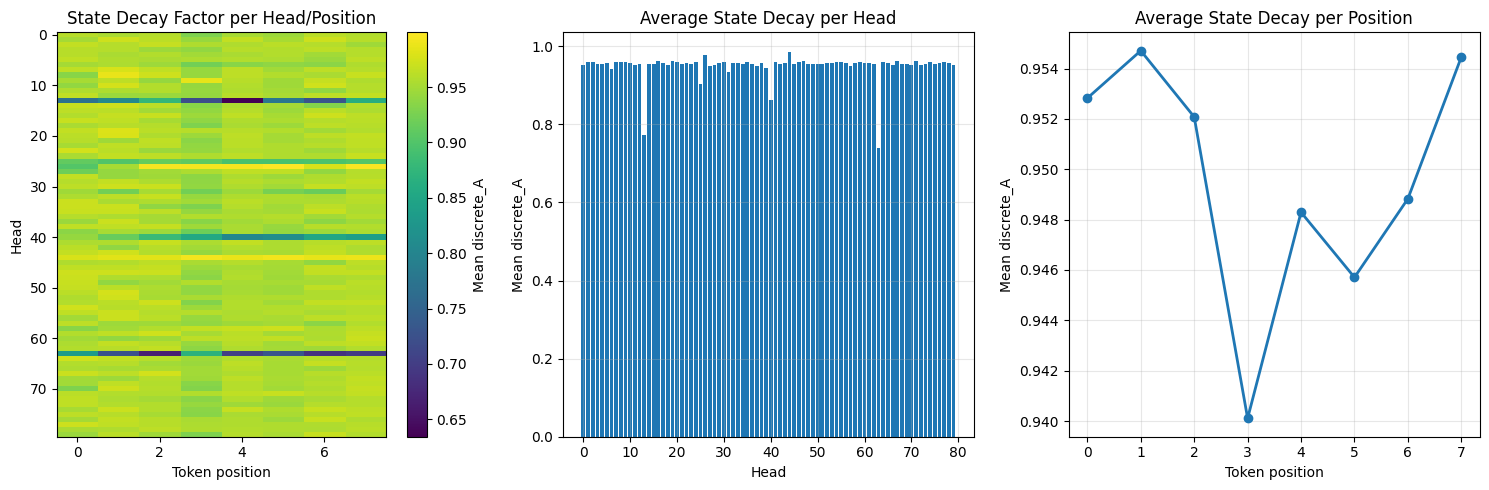

discrete_A statistics:
  Min:  0.634315
  Max:  0.999433
  Mean: 0.949625
  Std:  0.037251

💡 A ≈ 1: States are well-preserved
💡 A < 1: States decay over time (exponential forgetting)


In [18]:
# 分析discrete_A的分布
A_vals = discrete_A[0]  # [seqlen, nheads, headdim, d_state]

# 计算每个位置每个head的平均A值
A_mean_per_head = A_vals.mean(dim=(2, 3))  # [seqlen, nheads]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(A_mean_per_head.cpu().numpy().T, aspect='auto', cmap='viridis')
plt.colorbar(label='Mean discrete_A')
plt.xlabel('Token position')
plt.ylabel('Head')
plt.title('State Decay Factor per Head/Position')

plt.subplot(1, 3, 2)
# 每个head在所有位置的平均A值
A_per_head = A_mean_per_head.mean(dim=0).cpu().numpy()
plt.bar(range(len(A_per_head)), A_per_head)
plt.xlabel('Head')
plt.ylabel('Mean discrete_A')
plt.title('Average State Decay per Head')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# 每个位置在所有head的平均A值
A_per_pos = A_mean_per_head.mean(dim=1).cpu().numpy()
plt.plot(A_per_pos, marker='o', linewidth=2)
plt.xlabel('Token position')
plt.ylabel('Mean discrete_A')
plt.title('Average State Decay per Position')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"discrete_A statistics:")
print(f"  Min:  {A_vals.min().item():.6f}")
print(f"  Max:  {A_vals.max().item():.6f}")
print(f"  Mean: {A_vals.mean().item():.6f}")
print(f"  Std:  {A_vals.std().item():.6f}")
print(f"\n💡 A ≈ 1: States are well-preserved")
print(f"💡 A < 1: States decay over time (exponential forgetting)")

## 15. 探索：状态衰减因子A的分布

分析不同位置、不同head的A值

In [ ]:
# 用alpha_ssm重构（不含D）
y_without_D = torch.einsum('ijhp,jhp->ihp', alpha_ssm, x[0])

# 用alpha_complete重构（含D）
y_with_D = torch.einsum('ijhp,jhp->ihp', alpha_complete, x[0])

# D的直接贡献
D_contribution = y_with_D - y_without_D

print("【D参数的影响】")
print(f"\nOutput without D:")
print(f"  Mean: {y_without_D.mean().item():.6f}")
print(f"  Std:  {y_without_D.std().item():.6f}")

print(f"\nOutput with D:")
print(f"  Mean: {y_with_D.mean().item():.6f}")
print(f"  Std:  {y_with_D.std().item():.6f}")

print(f"\nD contribution (skip connection):")
print(f"  Mean: {D_contribution.mean().item():.6f}")
print(f"  Std:  {D_contribution.std().item():.6f}")

# 可视化D的贡献
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(y_without_D[:, 0, :].cpu().numpy().T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Token position')
plt.ylabel('Headdim')
plt.title('Output without D (SSM only)')

plt.subplot(1, 3, 2)
plt.imshow(y_with_D[:, 0, :].cpu().numpy().T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Token position')
plt.ylabel('Headdim')
plt.title('Output with D (SSM + skip)')

plt.subplot(1, 3, 3)
plt.imshow(D_contribution[:, 0, :].cpu().numpy().T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Token position')
plt.ylabel('Headdim')
plt.title('D contribution (skip connection)')

plt.tight_layout()
plt.show()

print(f"\n💡 D acts as a skip connection: y = SSM(x) + D*x")

## 14. 探索：D参数的作用

对比有无D的输出差异